# Introduction to the project: Battle of neighbourhoods

### A description of the problem and a discussion of the background

***Problem***: A group of stakeholders had recruited me to find and suggest a best place to start a Restaurant/hotel in the capital of Tamil Nadu, India. This problem revolves around gathering information about that city's geographical information and also collecting information about existing hotels in the given area which is a great factor that affects the current problem. The group of stakeholders are from a startup company so they need the result to give the needs according to that.

***Disscussion of the background***: The group of stakeholders are from a starup hence, their scale is a small-scale. Hence we have to collect the data of the neighbourhoods of the chennai city and their co-ordinates of each neighbourhoods. Also aqcuiring the data of the existing hotels which can be accomplished by using foursquare service. We need to combine all these data and choose a methodology to process the data and to get the result.

It is clear that the data required for this problem must contain maxiumum number of neighbourhood in the chennai city and we should get their co-ordinates in order to locate them on the map model using a module on python called follium and the existing hotels/restaurants in the city and that can be obtained from the foursquare services

### A description of the data and how it will be used to solve the problem.

In this problem we can acquire the data of the neighbourhoods of the chennai city and also, each one of their co-ordinates are given in the link https://krishblazer.000webhostapp.com/ which makes our job little easy. 
We can use this link to scrape the data from the page using beautifulsoup and parse it according to our needs and use pandas to create a dataset and follium to mark the scraped in the map

Foursquare will help us to get the crucial places like the hotels and popular places that people visit so that they might need the food and as we are going to deploy hotels that data is essential for more accurate result.

Let us start by installing and importing the nessessary Libraries and modules

In [70]:
#!pip install folium
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
import re
import numpy as np
import folium
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline


#### Scraping the required data of the city and it's neighbourhoods 

The required data of the city's neighbourhoods as well as their co-ordinates can be scraped through the following website: https://krishblazer.000webhostapp.com/

In [71]:
url = 'https://krishblazer.000webhostapp.com'

html = requests.get(url)
print(html)

<Response [200]>


Scraping with beautiful soup

In [7]:
soup = BeautifulSoup(html.text, 'html.parser')
table = soup.find("table", attrs={"class": "TBox"})

In [72]:
data = []
index = ['S.No.', 'Location', 'Latitude', 'Longitude']
for tr in table.find_all("tr", attrs={"class": "tab"}):
    t_row = {}
    for td, th in zip(tr.find_all("td"), index): 
        t_row[th] = td.text.replace('\n', '').strip()
    data.append(t_row)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
city_data = pd.DataFrame(data[:-1], columns=index)
city_data.drop(columns=['S.No.'], inplace=True)
city_data.at[0,'Location'] = 'Adyar Bus Debot'
city_data.rename(columns={'Location': 'Neighborhood'}, inplace=True)
print(city_data.shape)
city_data.head()

(105, 3)


,Neighborhood,Latitude,Longitude
0,Adyar Bus Debot,12.99722222,80.25694444
1,Adyar Signal,13.00638889,80.2575
2,Alandur,13.00777778,80.20972222
3,Ambattur,13.11,80.17
4,Anna Arch,13.07444444,80.21833333



Using ***folium*** to visualize the scarped dataset and using ***geolocator*** library

In [9]:
addr = 'Chennai, Tamil Nadu'

geolocator = Nominatim(user_agent="chennai_explorer")
location = geolocator.geocode(addr)
latitude = location.latitude
longitude = location.longitude
print('The coordinates of the chennai city is {}, {}.'.format(latitude, longitude))


The coordinates of the chennai city is 13.0836939, 80.270186.


In [13]:
cmap = folium.Map(location=[latitude, longitude], zoom_start=11)    
cmap

##### Lets mark the neighbourhoodson the city

In [14]:
for lat, lng, location in zip(city_data['Latitude'], city_data['Longitude'], city_data['Neighborhood']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(cmap)  

cmap

#### Using Foursquare services

In [73]:
CLIENT_ID = 'Y3LRYMN0B3I4EF4MBKXT4R0RG0IWDC01ORJZVO0SGFOURYB0' # your Foursquare ID
CLIENT_SECRET = 'OCMW3FPIEAPRBR3WZ1H4LIBJUCROF0HRHEHLJLQC2V0CNKQF' # your Foursquare Secret
ACCESS_TOKEN = 'RNFAZHVEG1ZUKLVF1T5E3UDDV3PRBRSSWMTLNRBOBTUILESK' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30

In [74]:
def neighbourhoods(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
        count = 1
        while count != 5:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                count = 5
            except:
                count += 1
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [75]:
chennai_venues = neighbourhoods(names = city_data['Neighborhood'],
                                 latitudes = city_data['Latitude'],
                                 longitudes = city_data['Longitude']
                                 )

print(chennai_venues.shape)
chennai_venues.head()

(1146, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adyar Bus Debot,12.99722222,80.25694444,Zaitoon Restaurant,12.996861,80.256178,Middle Eastern Restaurant
1,Adyar Bus Debot,12.99722222,80.25694444,Kuttanadu Restaurant,12.997010,80.257799,Asian Restaurant
2,Adyar Bus Debot,12.99722222,80.25694444,Zha Cafe,12.999730,80.254806,Café
3,Adyar Bus Debot,12.99722222,80.25694444,"Adyar Ananda Bhavan, Besant Nagar",12.996678,80.258275,Fast Food Restaurant
4,Adyar Bus Debot,12.99722222,80.25694444,Kovai Pazhamudir Nilayam,12.996522,80.259776,Fruit & Vegetable Store


In [76]:
chennai_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
AVM Studio,5,5,5,5,5,5
Adyar Bus Debot,17,17,17,17,17,17
Adyar Signal,31,31,31,31,31,31
Alandur,13,13,13,13,13,13
Ambattur,1,1,1,1,1,1
Anna Arch,13,13,13,13,13,13
Anna Nagar Roundana,20,20,20,20,20,20
Anna Nagar West Terminus,7,7,7,7,7,7
Anna Statue,13,13,13,13,13,13


In [77]:
print('There are {} uniques categories.'.format(len(chennai_venues['Venue Category'].unique())))

There are 141 uniques categories.


### ***Methodology*** 

As the neighborhoods data of the city and the most popular venues in each neighborhood obtained using Foursquare API, 141 unique categories has been found but to create a good analysis let's consider only the neighborhoods with more than 10 venues as some of the venues has less than 10 which wont get us to the required accuracy

We can perform one hot encoding on the obtained data set and use it find the 10 most common venue category in each neighborhood. Then clustering can be performed on the dataset. Here K - Nearest Neighbor clustering technique have been used. To find the optimal number of clusters silhouette score metric technique is used.

The clusters obtained can be analyzed to find the major type of venue categories in each cluster. This data can be used to suggest business people, suitable locations based on the category.

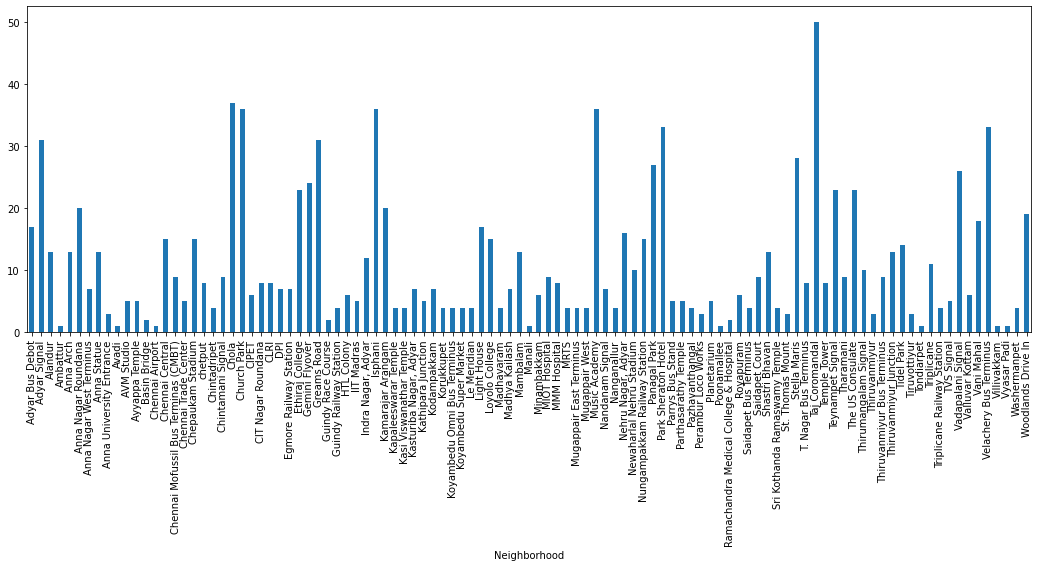

In [78]:
df = chennai_venues.groupby(['Neighborhood'], sort=False)['Venue'].count()
df.plot.bar(figsize=(18,6))

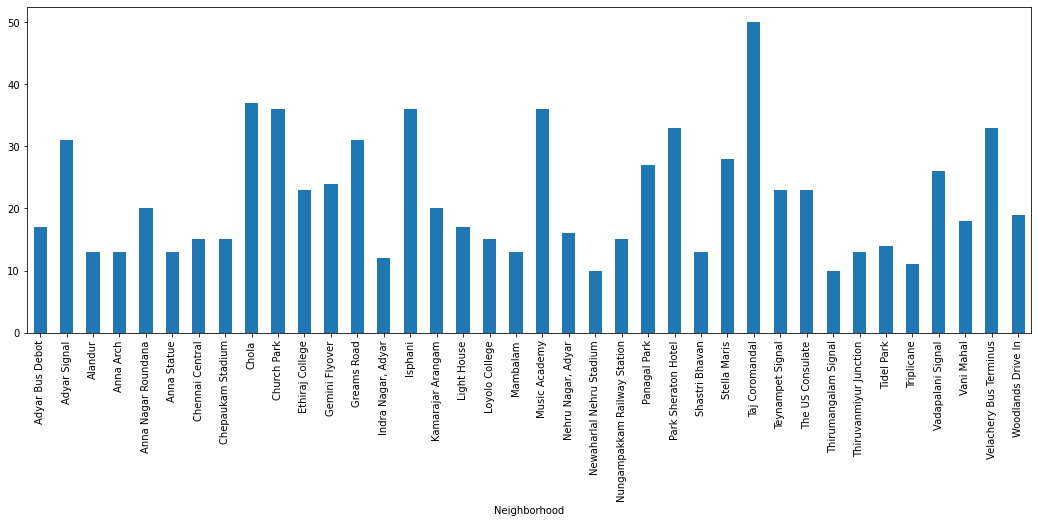

In [79]:
df = df[df >= 10]
df.plot.bar(figsize=(18,6))

In [80]:
chennai_venues_top = chennai_venues[chennai_venues['Neighborhood'].isin(df.index.tolist())]
chennai_venues_top.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adyar Bus Debot,12.99722222,80.25694444,Zaitoon Restaurant,12.996861,80.256178,Middle Eastern Restaurant
1,Adyar Bus Debot,12.99722222,80.25694444,Kuttanadu Restaurant,12.997010,80.257799,Asian Restaurant
2,Adyar Bus Debot,12.99722222,80.25694444,Zha Cafe,12.999730,80.254806,Café
3,Adyar Bus Debot,12.99722222,80.25694444,"Adyar Ananda Bhavan, Besant Nagar",12.996678,80.258275,Fast Food Restaurant
4,Adyar Bus Debot,12.99722222,80.25694444,Kovai Pazhamudir Nilayam,12.996522,80.259776,Fruit & Vegetable Store


### One hot encoding

In [81]:
chennai_onehot = pd.get_dummies(chennai_venues_top['Venue Category'], prefix="", prefix_sep="")
chennai_onehot['Neighborhood'] = chennai_venues_top['Neighborhood'] 
fixed_columns = chennai_onehot.columns.tolist()
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighborhood')))
chennai_onehot = chennai_onehot.reindex(columns = fixed_columns)
print(chennai_onehot.shape)
chennai_onehot.head()

(819, 111)


,Neighborhood,Accessories Store,African Restaurant,Airport,American Restaurant,Amphitheater,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beach,Bengali Restaurant,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Buffet,Bus Line,Bus Station,Business Service,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Department Store,Dessert Shop,Diner,Donut Shop,Electronics Store,Fast Food Restaurant,Flea Market,Food Court,Fried Chicken Joint,Fruit & Vegetable Store,Gaming Cafe,Garden,General Entertainment,Gourmet Shop,Grocery Store,Gym,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kerala Restaurant,Kids Store,Korean Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Store,Music Venue,Nightclub,North Indian Restaurant,Office,Paper / Office Supplies Store,Park,Pizza Place,Platform,Pool,Print Shop,Pub,Recreation Center,Restaurant,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Shopping Mall,Snack Place,Soccer Stadium,South Indian Restaurant,Spa,Sporting Goods Shop,Steakhouse,Tea Room,Thai Restaurant,Theater,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Adyar Bus Debot,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [82]:
chennai_grouped = chennai_onehot.groupby('Neighborhood').mean().reset_index()
print(chennai_grouped.shape)
chennai_grouped.head()


(38, 111)


,Neighborhood,Accessories Store,African Restaurant,Airport,American Restaurant,Amphitheater,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beach,Bengali Restaurant,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Buffet,Bus Line,Bus Station,Business Service,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Department Store,Dessert Shop,Diner,Donut Shop,Electronics Store,Fast Food Restaurant,Flea Market,Food Court,Fried Chicken Joint,Fruit & Vegetable Store,Gaming Cafe,Garden,General Entertainment,Gourmet Shop,Grocery Store,Gym,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kerala Restaurant,Kids Store,Korean Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Store,Music Venue,Nightclub,North Indian Restaurant,Office,Paper / Office Supplies Store,Park,Pizza Place,Platform,Pool,Print Shop,Pub,Recreation Center,Restaurant,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Shopping Mall,Snack Place,Soccer Stadium,South Indian Restaurant,Spa,Sporting Goods Shop,Steakhouse,Tea Room,Thai Restaurant,Theater,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Adyar Bus Debot,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.117647,0.0,0.058824,0.058824,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.058824,0.0,0.000000,0.000000,0.0,0.058824,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.117647,0.0,0.0,0.058824,0.058824,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.176471,0.000000,0.0,0.0,0.000000,0.0,0.0,0.058824,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.058824,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.058824,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Adyar Signal,0.0,0.0,0.000000,0.0,0.0,0.032258,0.0,0.032258,0.0,0.000000,0.032258,0.0,0.000000,0.0,0.0,0.0,0.032258,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.032258,0.0,0.0,0.000000,0.032258,0.0,0.0,0.0,0.0,0.0,0.0,0.032258,0.0,0.0,0.064516,0.032258,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.032258,0.032258,0.0,0.0,0.000000,0.000000,0.032258,0.290323,0.032258,0.0,0.0,0.032258,0.0,0.0,0.000000,0.0,0.0,0.032258,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.032258,0.0,0.000000,0.0,0.0,0.0,0.064516,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.032258,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.032258,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.032258,0.0
2,Alandur,0.0,0.0,0.076923,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.076923,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.076923,0.153846,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.153846,0.076923,0.000000,0.153846,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.076923,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.153846,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Anna Arch,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.076923,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.076923,0.0,0.0,0.153846,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.076923,0.153846,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0

In [83]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [84]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chennai_grouped['Neighborhood']
for ind in np.arange(chennai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chennai_grouped.iloc[ind, :], num_top_venues)
neighborhoods_venues_sorted.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Bus Debot,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Bakery,Middle Eastern Restaurant,Sandwich Place,Fried Chicken Joint,Fruit & Vegetable Store,Kids Store,BBQ Joint
1,Adyar Signal,Indian Restaurant,Electronics Store,North Indian Restaurant,Grocery Store,Juice Bar,Coffee Shop,Dessert Shop,Café,Fast Food Restaurant,Lounge
2,Alandur,Indian Restaurant,South Indian Restaurant,Hotel,Bus Station,Metro Station,Bus Line,Bar,Hotel Bar,Airport,Asian Restaurant
3,Anna Arch,Fast Food Restaurant,Clothing Store,Multiplex,Café,Sporting Goods Shop,Pizza Place,Shopping Mall,Scenic Lookout,Electronics Store,Bookstore
4,Anna Nagar Roundana,Indian Restaurant,Chinese Restaurant,Bookstore,Vegetarian / Vegan Restaurant,Juice Bar,Fast Food Restaurant,Electronics Store,Middle Eastern Restaurant,Coffee Shop,Clothing Store


### Clustering 

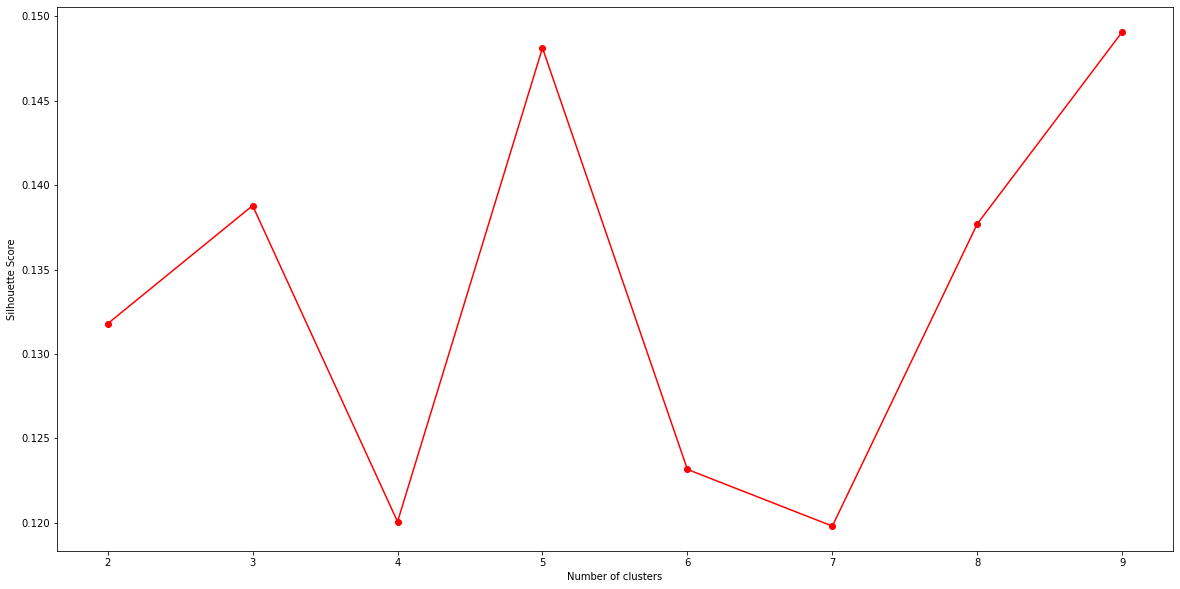

In [85]:
chennai_grouped_clustering = chennai_grouped.drop('Neighborhood', 1)
max_score = 10
scores = []
for kclusters in range(2, max_score):
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(chennai_grouped_clustering)
    score = silhouette_score(chennai_grouped_clustering, kmeans)
    scores.append(score)
plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

In [86]:
kclusters = 10
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chennai_grouped_clustering)
kmeans.labels_[0:11]

array([2, 2, 5, 0, 2, 3, 6, 5, 5, 9, 5], dtype=int32)

In [87]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
chennai_merged = chennai_venues_top[chennai_venues_top.columns[0:3]].drop_duplicates()
chennai_merged.reset_index(drop = True, inplace = True)
chennai_merged = chennai_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
chennai_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Bus Debot,12.99722222,80.25694444,2,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Bakery,Middle Eastern Restaurant,Sandwich Place,Fried Chicken Joint,Fruit & Vegetable Store,Kids Store,BBQ Joint
1,Adyar Signal,13.00638889,80.2575,2,Indian Restaurant,Electronics Store,North Indian Restaurant,Grocery Store,Juice Bar,Coffee Shop,Dessert Shop,Café,Fast Food Restaurant,Lounge
2,Alandur,13.00777778,80.20972222,5,Indian Restaurant,South Indian Restaurant,Hotel,Bus Station,Metro Station,Bus Line,Bar,Hotel Bar,Airport,Asian Restaurant
3,Anna Arch,13.07444444,80.21833333,0,Fast Food Restaurant,Clothing Store,Multiplex,Café,Sporting Goods Shop,Pizza Place,Shopping Mall,Scenic Lookout,Electronics Store,Bookstore
4,Anna Nagar Roundana,13.08444444,80.21805556,2,Indian Restaurant,Chinese Restaurant,Bookstore,Vegetarian / Vegan Restaurant,Juice Bar,Fast Food Restaurant,Electronics Store,Middle Eastern Restaurant,Coffee Shop,Clothing Store


### ***Cluster 1***

In [88]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Anna Arch,Fast Food Restaurant,Clothing Store,Multiplex,Café,Sporting Goods Shop,Pizza Place,Shopping Mall,Scenic Lookout,Electronics Store,Bookstore
16,Light House,Fast Food Restaurant,Coffee Shop,Snack Place,Beach,Bar,Multiplex,Sandwich Place,Sculpture Garden,Shopping Mall,Business Service
17,Loyolo College,Train Station,Women's Store,Bakery,Vegetarian / Vegan Restaurant,Gourmet Shop,Fast Food Restaurant,Mexican Restaurant,Department Store,Clothing Store,Café
22,Nungampakkam Railway Station,Indian Restaurant,Department Store,Mexican Restaurant,Asian Restaurant,Chinese Restaurant,Clothing Store,Fast Food Restaurant,Ice Cream Shop,Vegetarian / Vegan Restaurant,Italian Restaurant
34,Vadapalani Signal,Multiplex,Indian Restaurant,Clothing Store,Asian Restaurant,South Indian Restaurant,Fast Food Restaurant,Shopping Mall,Music Store,Café,Pizza Place


In [89]:
cluster1 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))
print(venues1.value_counts().head(10))


Fast Food Restaurant             5
Clothing Store                   4
Shopping Mall                    3
Multiplex                        3
Café                             3
Department Store                 2
Indian Restaurant                2
Asian Restaurant                 2
Pizza Place                      2
Vegetarian / Vegan Restaurant    2
dtype: int64


### ***Cluster 2***

In [90]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Gemini Flyover,Indian Restaurant,Sandwich Place,Coffee Shop,Nightclub,Hotel,Café,Thai Restaurant,Chinese Restaurant,Department Store,Lounge
14,Isphani,Indian Restaurant,Hotel,Chinese Restaurant,South Indian Restaurant,Lounge,Coffee Shop,Café,Pizza Place,Sandwich Place,Nightclub
15,Kamarajar Arangam,Café,Indian Restaurant,Nightclub,Hotel,Lounge,Amphitheater,Concert Hall,Ice Cream Shop,South Indian Restaurant,BBQ Joint
24,Park Sheraton Hotel,Hotel,Café,Indian Restaurant,Restaurant,Italian Restaurant,Japanese Restaurant,Coffee Shop,Chinese Restaurant,Nightclub,Thai Restaurant
29,The US Consulate,Indian Restaurant,Sandwich Place,Coffee Shop,Nightclub,Hotel,Tea Room,Thai Restaurant,Lounge,Department Store,Chinese Restaurant
37,Woodlands Drive In,Indian Restaurant,Nightclub,Hotel,Chinese Restaurant,Department Store,Pool,Coffee Shop,Bar,Park,BBQ Joint


In [91]:
cluster2 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))

print(venues2.value_counts().head(10))

Hotel                 6
Nightclub             6
Indian Restaurant     6
Coffee Shop           5
Chinese Restaurant    5
Lounge                4
Café                  4
Sandwich Place        3
Department Store      3
Thai Restaurant       3
dtype: int64


### ***Cluster 3***

In [92]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 2, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Bus Debot,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Bakery,Middle Eastern Restaurant,Sandwich Place,Fried Chicken Joint,Fruit & Vegetable Store,Kids Store,BBQ Joint
1,Adyar Signal,Indian Restaurant,Electronics Store,North Indian Restaurant,Grocery Store,Juice Bar,Coffee Shop,Dessert Shop,Café,Fast Food Restaurant,Lounge
4,Anna Nagar Roundana,Indian Restaurant,Chinese Restaurant,Bookstore,Vegetarian / Vegan Restaurant,Juice Bar,Fast Food Restaurant,Electronics Store,Middle Eastern Restaurant,Coffee Shop,Clothing Store
13,"Indra Nagar, Adyar",Indian Restaurant,Café,Sandwich Place,Breakfast Spot,Chinese Restaurant,Department Store,Ice Cream Shop,Juice Bar,Pizza Place,Women's Store
20,"Nehru Nagar, Adyar",Indian Restaurant,Café,Chinese Restaurant,Pizza Place,Sandwich Place,Department Store,Ice Cream Shop,Women's Store,Spa,Donut Shop
27,Taj Coromandal,Indian Restaurant,Café,Sandwich Place,Chinese Restaurant,Italian Restaurant,Ice Cream Shop,Dessert Shop,Asian Restaurant,Chocolate Shop,Pizza Place
30,Thirumangalam Signal,Indian Restaurant,Jewelry Store,Market,Mobile Phone Shop,Print Shop,Bus Station,Pizza Place,Café,Vegetarian / Vegan Restaurant,Cosmetics Shop
36,Velachery Bus Terminus,Indian Restaurant,Fast Food Restaurant,Restaurant,Chinese Restaurant,Clothing Store,Bar,Coffee Shop,Department Store,Electronics Store,Ice Cream Shop


In [93]:
cluster3 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 2, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues3 = (cluster3['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue']).append(
    cluster3['6th Most Common Venue']).append(
    cluster3['7th Most Common Venue']).append(
    cluster3['8th Most Common Venue']).append(
    cluster3['9th Most Common Venue']).append(
    cluster3['10th Most Common Venue']))

print(venues3.value_counts().head(10))

Indian Restaurant       8
Café                    5
Chinese Restaurant      5
Fast Food Restaurant    4
Ice Cream Shop          4
Sandwich Place          4
Pizza Place             4
Juice Bar               3
Electronics Store       3
Department Store        3
dtype: int64


### ***Cluster 4***

In [94]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 3, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Anna Statue,Indian Restaurant,Multiplex,Electronics Store,General Entertainment,Movie Theater,Dessert Shop,Flea Market,Comfort Food Restaurant,Concert Hall,Convenience Store
33,Triplicane,Indian Restaurant,Multiplex,General Entertainment,Dessert Shop,Electronics Store,Fast Food Restaurant,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop


In [95]:
cluster4 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 3, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues4 = (cluster4['1st Most Common Venue'].append(
    cluster4['2nd Most Common Venue']).append(
    cluster4['3rd Most Common Venue']).append(
    cluster4['4th Most Common Venue']).append(
    cluster4['5th Most Common Venue']).append(
    cluster4['6th Most Common Venue']).append(
    cluster4['7th Most Common Venue']).append(
    cluster4['8th Most Common Venue']).append(
    cluster4['9th Most Common Venue']).append(
    cluster4['10th Most Common Venue']))

print(venues4.value_counts().head(10))

Dessert Shop               2
Concert Hall               2
Multiplex                  2
Indian Restaurant          2
General Entertainment      2
Electronics Store          2
Convenience Store          2
Comfort Food Restaurant    2
Cosmetics Shop             1
Flea Market                1
dtype: int64


### ***Cluster 5***

In [96]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 4, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Mambalam,Clothing Store,Indian Restaurant,Asian Restaurant,Boutique,Department Store,Miscellaneous Shop,Snack Place,South Indian Restaurant,Jewelry Store,Train Station
23,Panagal Park,Clothing Store,Indian Restaurant,Jewelry Store,Shopping Mall,BBQ Joint,Boutique,Coffee Shop,Dessert Shop,Vegetarian / Vegan Restaurant,Miscellaneous Shop


In [97]:
cluster5 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 4, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues5 = (cluster5['1st Most Common Venue'].append(
    cluster5['2nd Most Common Venue']).append(
    cluster5['3rd Most Common Venue']).append(
    cluster5['4th Most Common Venue']).append(
    cluster5['5th Most Common Venue']).append(
    cluster5['6th Most Common Venue']).append(
    cluster5['7th Most Common Venue']).append(
    cluster5['8th Most Common Venue']).append(
    cluster5['9th Most Common Venue']).append(
    cluster5['10th Most Common Venue']))

print(venues5.value_counts().head(10))

Indian Restaurant          2
Clothing Store             2
Miscellaneous Shop         2
Boutique                   2
Jewelry Store              2
Dessert Shop               1
Shopping Mall              1
South Indian Restaurant    1
Department Store           1
BBQ Joint                  1
dtype: int64


### ***Cluster 6***

In [98]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 5, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Alandur,Indian Restaurant,South Indian Restaurant,Hotel,Bus Station,Metro Station,Bus Line,Bar,Hotel Bar,Airport,Asian Restaurant
7,Chepaukam Stadium,Indian Restaurant,Hotel,General Entertainment,Mediterranean Restaurant,Bar,Breakfast Spot,Bookstore,Electronics Store,Café,Multiplex
8,Chola,Indian Restaurant,Hotel,Ice Cream Shop,Concert Hall,Restaurant,Electronics Store,Café,Chinese Restaurant,Comfort Food Restaurant,Mexican Restaurant
10,Ethiraj College,Hotel,Indian Restaurant,Café,Pizza Place,Kebab Restaurant,Juice Bar,Shopping Mall,Middle Eastern Restaurant,Mexican Restaurant,Donut Shop
19,Music Academy,Indian Restaurant,Hotel,Restaurant,Café,Concert Hall,Garden,Juice Bar,Italian Restaurant,Ice Cream Shop,Gym
26,Stella Maris,Indian Restaurant,Hotel,Garden,Kerala Restaurant,Juice Bar,Jewelry Store,Italian Restaurant,Ice Cream Shop,Fast Food Restaurant,Restaurant
28,Teynampet Signal,Indian Restaurant,Lounge,Hotel,Pub,Pizza Place,Italian Restaurant,Chinese Restaurant,Café,Juice Bar,Clothing Store
35,Vani Mahal,Indian Restaurant,Hotel,Coffee Shop,Clothing Store,Department Store,Recreation Center,Pub,BBQ Joint,Music Venue,Vegetarian / Vegan Restaurant


In [99]:
cluster6 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 5, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues6 = (cluster6['1st Most Common Venue'].append(
    cluster6['2nd Most Common Venue']).append(
    cluster6['3rd Most Common Venue']).append(
    cluster6['4th Most Common Venue']).append(
    cluster6['5th Most Common Venue']).append(
    cluster6['6th Most Common Venue']).append(
    cluster6['7th Most Common Venue']).append(
    cluster6['8th Most Common Venue']).append(
    cluster6['9th Most Common Venue']).append(
    cluster6['10th Most Common Venue']))

print(venues6.value_counts().head(10))

Indian Restaurant     8
Hotel                 8
Café                  5
Juice Bar             4
Restaurant            3
Ice Cream Shop        3
Italian Restaurant    3
Bar                   2
Pub                   2
Chinese Restaurant    2
dtype: int64


### ***Cluster 7***

In [100]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 6, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Chennai Central,Indian Restaurant,Platform,Bookstore,Train Station,Nightclub,Vegetarian / Vegan Restaurant,Hotel,Metro Station,Sandwich Place,Bus Station
21,Newaharlal Nehru Stadium,Indian Restaurant,Platform,Bookstore,Soccer Stadium,Sandwich Place,Train Station,Vegetarian / Vegan Restaurant,Grocery Store,Gourmet Shop,Coffee Shop


In [101]:
cluster7 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 6, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues7 = (cluster7['1st Most Common Venue'].append(
    cluster7['2nd Most Common Venue']).append(
    cluster7['3rd Most Common Venue']).append(
    cluster7['4th Most Common Venue']).append(
    cluster7['5th Most Common Venue']).append(
    cluster7['6th Most Common Venue']).append(
    cluster7['7th Most Common Venue']).append(
    cluster7['8th Most Common Venue']).append(
    cluster7['9th Most Common Venue']).append(
    cluster7['10th Most Common Venue']))

print(venues7.value_counts().head(10))

Sandwich Place                   2
Platform                         2
Indian Restaurant                2
Vegetarian / Vegan Restaurant    2
Bookstore                        2
Train Station                    2
Coffee Shop                      1
Grocery Store                    1
Soccer Stadium                   1
Bus Station                      1
dtype: int64


### ***Cluster 8***

In [102]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 7, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Shastri Bhavan,Indian Restaurant,Chinese Restaurant,Theater,Japanese Restaurant,Convenience Store,Multicuisine Indian Restaurant,Asian Restaurant,Coffee Shop,Electronics Store,Concert Hall


In [103]:
cluster8 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 7, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues8 = (cluster8['1st Most Common Venue'].append(
    cluster8['2nd Most Common Venue']).append(
    cluster8['3rd Most Common Venue']).append(
    cluster8['4th Most Common Venue']).append(
    cluster8['5th Most Common Venue']).append(
    cluster8['6th Most Common Venue']).append(
    cluster8['7th Most Common Venue']).append(
    cluster8['8th Most Common Venue']).append(
    cluster8['9th Most Common Venue']).append(
    cluster8['10th Most Common Venue']))

print(venues8.value_counts().head(10))

Theater                           1
Concert Hall                      1
Asian Restaurant                  1
Multicuisine Indian Restaurant    1
Japanese Restaurant               1
Indian Restaurant                 1
Coffee Shop                       1
Electronics Store                 1
Convenience Store                 1
Chinese Restaurant                1
dtype: int64


Now, we have the every clusters so lets put them into comparison

In [1]:
Lets, analyse the clusters

SyntaxError: invalid syntax (<ipython-input-1-88185f17f4ec>, line 1)

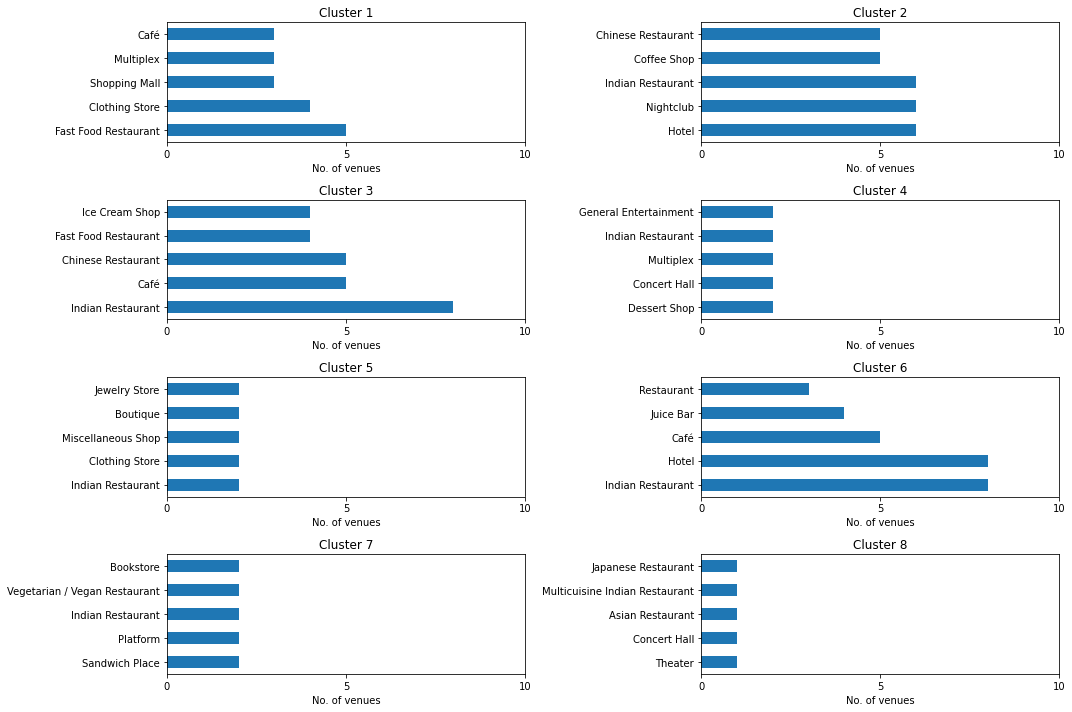

In [105]:
df_list = [venues1 ,venues2, venues3, venues4, venues5, venues6, venues7, venues8]
fig, axes = plt.subplots(4, 2)

count = 0
for r in range(4):
    for c in range(2):
        df_list[count].value_counts().head().plot.barh(ax = axes[r,c], width=0.5, figsize=(15,10))
        axes[r,c].set_title('Cluster {}'.format(count+1))
        plt.sca(axes[r, c])
        plt.xticks(np.arange(0, 15, 5))
        plt.xlabel('No. of venues')
        count += 1

fig.tight_layout()

#### ***Result:***

By the Bargraphs, we can clearly see that cluster 8 has the lowest number of hotels among every clusters but it isn't the optimal cluster to start a hotel as we need because the other popular places or venues in that cluster is also very low, where it will affect our result as people not coming to those places more hence our optimal cluster should contain less number of hotels also with high number of popular venues. Hence, cluster 4 and cluster 5 will be preffered for starting the hotel our stakeholders were looking for and those areas namely, Triplicane, Anna statue and Mambalam

### ***Discussion section:***

As of now, this project revolves around with the data availability in live so in upcoming future the big data will be available more and the result will become more and more 

### ***Conclusion section***

Hence, deploying hotels on Triplicane would be suggested to the startup stakeholders